In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'PredictionsLEUAuto.txt'
Data = pd.read_csv(file_path, sep=',')

Data['redundancy'] = round(Data['redundancy'], 1)
Data['relevance'] = round(Data['relevance'], 1)

# Display the contents of the DataFrame
print("Max AUC score",Data['AUCScore'].max())
print("Max Accuracy score",Data['AccuracyScore'].max())
print("Max AUC score",Data['AUCScore'].min())

Max AUC score 100.0
Max Accuracy score 100.0
Max AUC score 34.3


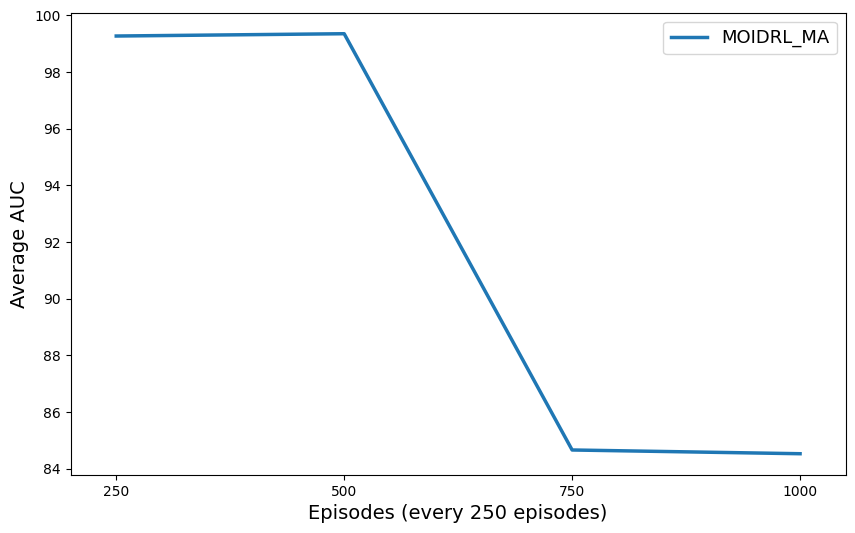

In [2]:
# Grouping data into chunks of 250 episodes and calculating the average reward
average_reward = Data.groupby(Data.index // 250)['AUCScore'].mean()

x_ticks = [250 * i for i in range(1, len(average_reward) + 1)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_ticks,average_reward, label='MOIDRL_MA',linewidth=2.5)

# Adding labels and title with increased font size
ax.set_xlabel('Episodes (every 250 episodes)', fontsize=14)
ax.set_ylabel('Average AUC', fontsize=14)
# ax.set_title("MLL", fontsize=16)

# Adding a legend with increased font size
ax.legend(fontsize=13)
# Setting the axis limits (échelle)
ax.set_xlim([200, 1050]) 

ax.set_xticks(x_ticks)

# plt.savefig('AUCBreast.pdf', format='pdf',dpi=800)  # Change dpi for higher resolution, e.g., 300, 600

# Show the plot
plt.show()

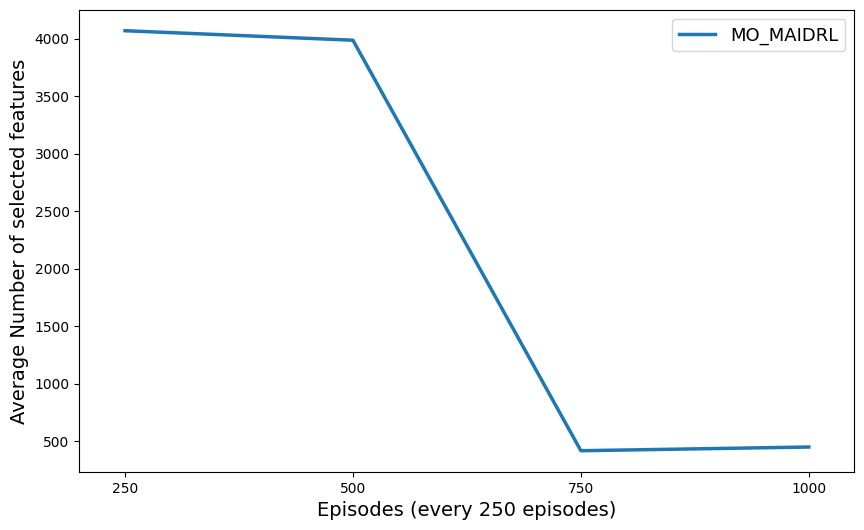

In [3]:
# Grouping data into chunks of 100 episodes and calculating the average reward
average_reward = Data.groupby(Data.index // 250)['FeatureNumber'].mean()

x_ticks = [250 * i for i in range(1, len(average_reward) + 1)]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_ticks,average_reward, label='MO_MAIDRL',linewidth=2.5)

ax.set_xlabel('Episodes (every 250 episodes)', fontsize=14)
ax.set_ylabel('Average Number of selected features', fontsize=14)
ax.legend(fontsize=13)

ax.set_xlim([200, 1050]) 
ax.set_xticks(x_ticks)
# plt.savefig('Fig03-6734.pdf', format='pdf',dpi=600)  # Change dpi for higher resolution, e.g., 300, 600
plt.show()

Text(0.5, 1.0, 'Data')

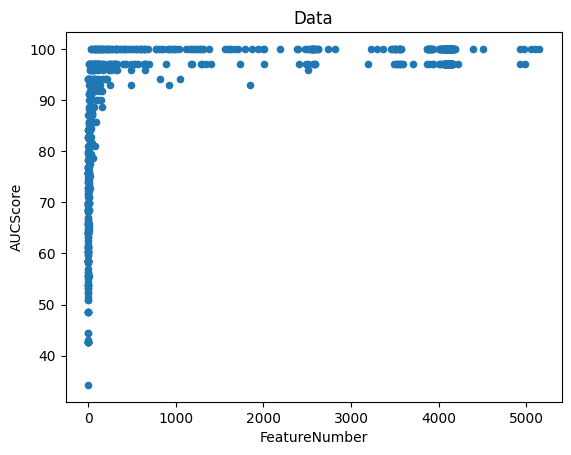

In [4]:
ax = Data.plot.scatter(x='FeatureNumber', y='AUCScore')
ax.set_title('Data')

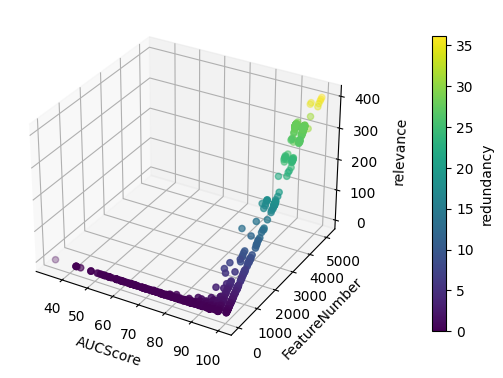

In [5]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(Data['AUCScore'], Data['FeatureNumber'], Data['relevance'], c=Data['redundancy'], cmap='viridis')

# Adjusting the color bar position
# You can tweak the `shrink` parameter or `pad` to move the color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.15)  # Shrink makes the bar smaller; pad controls distance
cbar.set_label('redundancy')  # Color bar label

# Labels
ax.set_xlabel('AUCScore')
ax.set_ylabel('FeatureNumber')
ax.set_zlabel('relevance',labelpad=7)

# plt.tight_layout()
# Show plot
plt.show()


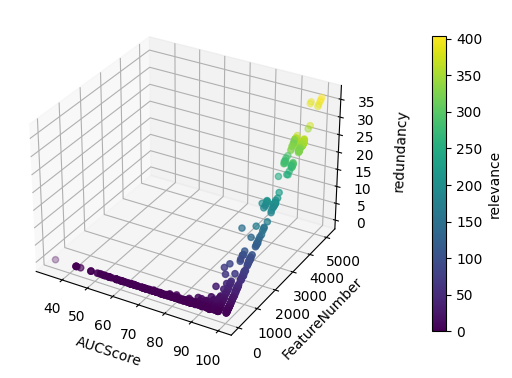

In [6]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(Data['AUCScore'], Data['FeatureNumber'], Data['redundancy'], c=Data['relevance'], cmap='viridis')

# Adjusting the color bar position
# You can tweak the `shrink` parameter or `pad` to move the color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.15)  # Shrink makes the bar smaller; pad controls distance
cbar.set_label('relevance')  # Color bar label

# Labels
ax.set_xlabel('AUCScore')
ax.set_ylabel('FeatureNumber')
ax.set_zlabel('redundancy',labelpad=7)

# plt.tight_layout()
# Show plot
plt.show()

In [7]:
def count_diffs(a, b, to_min, to_max):
    n_better = 0
    n_worse = 0

    for f in to_min:
        n_better += a[f] < b[f]
        n_worse += a[f] > b[f]

    for f in to_max:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse

def find_skyline_bnl(df, to_min, to_max):
    """Finds the skyline using a block-nested loop with 4 objectives."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_min, to_max)

            # Case 1: Current row i is dominated by row j
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 2: Row i dominates row j
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        # Remove dominated rows from the skyline
        skyline = skyline.difference(to_drop)
        # Add the current row i to the skyline
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

In [8]:
import time

tic = time.time()
skyline = find_skyline_bnl(df=Data, to_min=["FeatureNumber", "redundancy"], to_max=["AUCScore", "relevance"])
print(f'Block nested loop took {time.time() - tic:.3f} seconds', skyline)

Block nested loop took 0.025 seconds 0       True
1       True
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998     True
999     True
Length: 1000, dtype: bool


In [9]:
selected_items = []

for index, is_skyline in skyline.items():
    if is_skyline:
        selected_items.append(index)

print("Length of selected items:", len(selected_items), selected_items)

selected_data = Data.loc[selected_items]
# Save the merged DataFrame to a CSV file
selected_data.to_csv('Result_LEUAuto.csv', index=False)

Length of selected items: 179 [0, 1, 8, 9, 31, 96, 127, 150, 161, 173, 175, 181, 188, 192, 198, 199, 204, 208, 232, 237, 239, 251, 252, 254, 256, 257, 258, 287, 288, 292, 293, 294, 295, 307, 365, 367, 368, 432, 433, 434, 443, 451, 455, 458, 468, 469, 470, 472, 473, 474, 475, 477, 494, 501, 502, 503, 506, 507, 508, 512, 524, 525, 526, 540, 541, 542, 554, 556, 557, 558, 563, 564, 566, 568, 569, 570, 571, 576, 577, 581, 582, 583, 595, 596, 604, 605, 607, 621, 623, 648, 650, 651, 654, 660, 673, 675, 687, 688, 689, 690, 691, 692, 693, 713, 714, 715, 716, 722, 723, 724, 725, 730, 738, 742, 744, 746, 747, 748, 761, 762, 763, 764, 776, 777, 778, 780, 783, 792, 804, 807, 815, 816, 826, 827, 828, 829, 834, 840, 841, 842, 856, 857, 858, 861, 862, 868, 878, 879, 880, 881, 883, 889, 890, 891, 892, 905, 907, 918, 919, 920, 921, 922, 930, 931, 932, 942, 943, 944, 945, 955, 956, 970, 973, 982, 983, 985, 986, 998, 999]


In [10]:
print("AUCScore: ")
print("min", Data['AUCScore'].min())
print("max",Data['AUCScore'].max())
print("std",Data['AUCScore'].std())
print("mean",Data['AUCScore'].mean())

AUCScore: 
min 34.3
max 100.0
std 13.645239879216536
mean 91.9489


In [11]:
print("FeatureNumber : ")
print("min", Data['FeatureNumber'].min())
print("max",Data['FeatureNumber'].max())
print("std",Data['FeatureNumber'].std())
print("mean",Data['FeatureNumber'].mean())

FeatureNumber : 
min 1
max 5144
std 1927.3355116778641
mean 2229.76


In [12]:
df_selected_data = selected_data[
    (selected_data['AUCScore'] > (selected_data['AUCScore'].mean())) &
    (selected_data['FeatureNumber'] < (selected_data['FeatureNumber'].std()))
]
df_selected_data

,AccuracyScore,Reward,AUCScore,FeatureNumber,PrecisionScore,RecallScore,f1Score,relevance,redundancy,selected_features1
502,100.0,998053.7,100.0,975,100.0,100.0,100.0,81.1,6.6,"[4096, 2051, 6, 2055, 10, 4106, 16, 2065, 18, ..."
512,100.0,-815452.8,100.0,907,100.0,100.0,100.0,73.8,6.1,"[773, 3759, 3056, 769, 4460, 3885, 1834, 1436,..."
541,100.0,932886.2,100.0,955,100.0,100.0,100.0,76.1,7.0,"[0, 2048, 4101, 10, 11, 2059, 2062, 4112, 18, ..."
556,100.0,1435951.2,100.0,1168,100.0,100.0,100.0,94.6,8.2,"[1, 2049, 4, 2053, 4106, 13, 4110, 15, 2063, 2..."
557,100.0,338312.3,100.0,561,100.0,100.0,100.0,45.3,4.0,"[1, 2049, 2053, 2063, 15, 4111, 20, 2068, 2070..."
583,100.0,662120.3,100.0,771,100.0,100.0,100.0,58.9,5.7,"[2049, 2, 4097, 2052, 4104, 9, 11, 2062, 4113,..."
595,100.0,102701.9,100.0,316,100.0,100.0,100.0,24.3,2.4,"[0, 4, 2052, 8, 4109, 2063, 4114, 2088, 2090, ..."
607,100.0,172407.7,100.0,410,100.0,100.0,100.0,30.2,2.8,"[4097, 3, 4102, 7, 2059, 21, 2069, 4127, 33, 2..."
623,100.0,204810.4,100.0,444,100.0,100.0,100.0,37.1,3.0,"[4098, 2051, 7, 4106, 2068, 4118, 27, 2076, 29..."
650,100.0,1656049.9,100.0,1306,100.0,100.0,100.0,102.8,9.4,"[0, 1, 4, 9, 11, 13, 16, 22, 23, 30, 32, 39, 4..."


In [13]:
sorted_skyline = df_selected_data.sort_values(by=['AUCScore', 'FeatureNumber'], ascending=[False, True])
sorted_skyline

,AccuracyScore,Reward,AUCScore,FeatureNumber,PrecisionScore,RecallScore,f1Score,relevance,redundancy,selected_features1
920,100.0,1498.1,100.0,36,100.0,100.0,100.0,4.3,0.2,"[130, 4866, 771, 4490, 3211, 4114, 1686, 2715,..."
730,100.0,4833.7,100.0,64,100.0,100.0,100.0,5.3,0.4,"[1537, 2433, 3333, 1286, 5116, 269, 1166, 1805..."
862,100.0,5593.7,100.0,75,100.0,100.0,100.0,6.3,0.6,"[2816, 257, 1408, 3969, 3204, 387, 1671, 3081,..."
816,100.0,6420.1,100.0,77,100.0,100.0,100.0,7.2,0.4,"[5126, 2567, 2059, 2068, 549, 2598, 3625, 1579..."
919,100.0,6499.0,100.0,78,100.0,100.0,100.0,7.5,0.5,"[4097, 517, 2566, 4114, 1555, 1564, 2085, 39, ..."
692,100.0,9509.3,100.0,102,100.0,100.0,100.0,11.2,0.6,"[4097, 5123, 1544, 1545, 4113, 3609, 2074, 258..."
861,100.0,25790.8,100.0,150,100.0,100.0,100.0,11.3,1.1,"[1027, 1539, 2567, 3081, 3083, 3596, 3086, 513..."
660,100.0,-24827.7,100.0,159,100.0,100.0,100.0,11.7,1.0,"[2601, 2273, 3346, 367, 2789, 3104, 4508, 419,..."
815,100.0,-25406.6,100.0,161,100.0,100.0,100.0,13.9,1.0,"[2142, 4555, 2619, 3434, 1733, 955, 927, 974, ..."
918,100.0,24473.7,100.0,162,100.0,100.0,100.0,14.6,1.1,"[4097, 1538, 3, 517, 2566, 3086, 4114, 1555, 5..."


In [14]:
sorted_skyline.to_csv("paretoFront_LEU.csv", index=False)

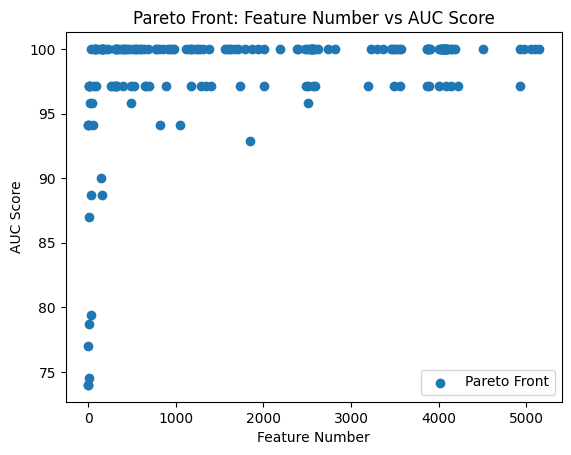

In [16]:
import matplotlib.pyplot as plt

plt.scatter(Data.loc[skyline, 'FeatureNumber'], Data.loc[skyline, 'AUCScore'], label='Pareto Front')
plt.xlabel('Feature Number')
plt.ylabel('AUC Score')
plt.title('Pareto Front: Feature Number vs AUC Score')
plt.legend()
plt.show()


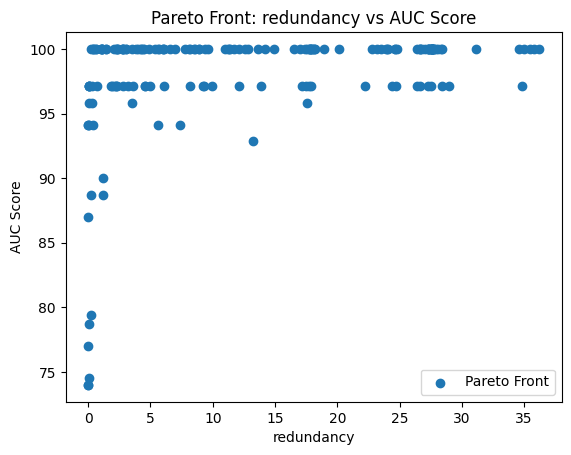

In [17]:
plt.scatter(Data.loc[skyline, 'redundancy'], Data.loc[skyline, 'AUCScore'], label='Pareto Front')
plt.xlabel('redundancy')
plt.ylabel('AUC Score')
plt.title('Pareto Front: redundancy vs AUC Score')
plt.legend()
plt.show()

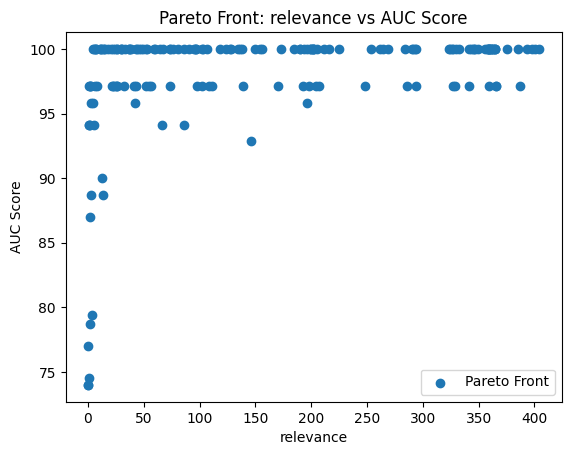

In [18]:
plt.scatter(Data.loc[skyline, 'relevance'], Data.loc[skyline, 'AUCScore'], label='Pareto Front')
plt.xlabel('relevance')
plt.ylabel('AUC Score')
plt.title('Pareto Front: relevance vs AUC Score')
plt.legend()
plt.show()

In [19]:
from sklearn.cluster import KMeans
import numpy as np

# Extract Pareto front points from your DataFrame
pareto_solutions = Data[skyline]

numeric_columns = pareto_solutions.select_dtypes(include=[np.number]).columns
pareto_solutions_numeric = pareto_solutions[numeric_columns]

# Apply KMeans clustering to reduce the number of solutions
n_clusters = 4  # Number of clusters you want to represent the Pareto front
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pareto_solutions_numeric)

# Get the cluster centers (representative points)
representative_solutions = pd.DataFrame(kmeans.cluster_centers_, columns=pareto_solutions_numeric.columns)
representative_solutions

C:\Users\Rahma Hellali\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,AccuracyScore,Reward,AUCScore,FeatureNumber,PrecisionScore,RecallScore,f1Score,relevance,redundancy
0,97.362687,-1.971027e+05,97.536567,1557.223881,97.362687,97.362687,97.362687,132.141045,10.688806
1,99.433333,-2.503107e+07,99.516667,5018.333333,99.433333,99.433333,99.433333,394.700000,35.316667
2,99.660000,-8.739538e+06,99.710000,2939.900000,99.660000,99.660000,99.660000,231.220000,20.690000
3,99.062069,3.923753e+06,99.155172,2288.931034,99.062069,99.062069,99.062069,181.317241,15.972414


In [20]:
from sklearn.cluster import KMeans
import numpy as np

columns_to_select = ['AUCScore', 'FeatureNumber', 'relevance', 'redundancy']

pareto_solutions = df_selected_data[columns_to_select]

numeric_columns = pareto_solutions.select_dtypes(include=[np.number]).columns
pareto_solutions_numeric = pareto_solutions[numeric_columns]

# Apply KMeans clustering to reduce the number of solutions
n_clusters = 10  # Number of clusters you want to represent the Pareto front
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pareto_solutions_numeric)

# Get the cluster centers (representative points)
representative_solutions = pd.DataFrame(kmeans.cluster_centers_, columns=pareto_solutions_numeric.columns)
representative_solutions

C:\Users\Rahma Hellali\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,AUCScore,FeatureNumber,relevance,redundancy
0,100.0,437.000000,34.742857,2.985714
1,100.0,1171.600000,92.780000,8.240000
2,100.0,72.000000,6.966667,0.450000
3,100.0,942.000000,76.225000,6.425000
4,100.0,1575.000000,121.250000,11.100000
5,100.0,592.857143,47.714286,4.242857
6,100.0,325.800000,25.460000,2.260000
7,100.0,176.000000,15.142857,1.157143
8,100.0,1304.750000,102.200000,9.200000
9,100.0,802.250000,62.575000,5.675000
